In [1]:
import seaborn as sns 

import os
import glob

import geopandas as gpd

import rasterio as rio
from rasterio.plot import plotting_extent

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.patches import Patch, Rectangle


import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from shapely import geometry

import pandas as pd
import numpy as np

## 4-panel Tuolumne Figure 

In [2]:
root = "/Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/ASO_3M_SD_USCATE_20180528/"
example = os.path.join(root, "/Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/ASO_3M_SD_USCATE_20180528/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-V2-2020-03-03-17-49-47-260:planet-snowcover-imagery:20180528_181109_1025_3B_AnalyticMS_SR_clip")

In [3]:
example_visual_image = rio.open(glob.glob(os.path.join(example, "*Visual_4326.tif"))[0])
example_visual_image_extent = plotting_extent(example_visual_image)

In [4]:
visualization_extent = gpd.read_file(os.path.join(example, "visualization_extent.geojson"))
visualization_extent = [
    visualization_extent.bounds.minx, 
    visualization_extent.bounds.maxx, 
    visualization_extent.bounds.miny, 
    visualization_extent.bounds.maxy
]

In [5]:
example_ml_predict = rio.open(glob.glob(os.path.join(example, "preds/*merged.tif"))[0])
example_ml_predict_extent = plotting_extent(example_ml_predict)
example_ml_predict_data = example_ml_predict.read(1, masked=True)
example_ml_predict_data.mask = example_ml_predict_data.mask & (example_ml_predict_data.data != 0)

In [6]:
example_aso_mask = rio.open(glob.glob(os.path.join(example, "mask/*merged.tif"))[0])
example_aso_mask_extent = plotting_extent(example_aso_mask)
example_aso_mask_data = example_aso_mask.read(1, masked=True)
example_aso_mask_data.mask = (example_aso_mask_data.mask & example_aso_mask.read(1, masked=True).mask) & (example_aso_mask_data.data != 1)

In [4]:
comparative_metrics = pd.read_csv(os.path.join(root, "performance_metrics.csv"))

In [5]:
comparative_metrics.head()

,Unnamed: 0,index,SCA,variable,value
0,0,0,CubeSat ML,Precision,0.364865
1,1,1,CubeSat ML,Precision,0.732788
2,2,2,CubeSat ML,Precision,0.839423
3,3,3,CubeSat ML,Precision,0.794919
4,4,4,CubeSat ML,Precision,0.697997


In [21]:
allmetrics_table = comparative_metrics.groupby(
    ['SCA', 'variable']
).apply(
    lambda x: pd.Series([np.mean(x.value), np.std(x.value)])
).rename({
    0: 'Mean', 
    1: "Standard Deviation"
}, axis=1).round(2)
allmetrics_table                             

Mean  Standard Deviation
SCA             variable                                   
CubeSat ML      Balanced Accuracy  0.82                0.07
                F-Score            0.73                0.12
                Kappa              0.61                0.18
                Precision          0.69                0.15
                Recall             0.82                0.12
Landsat 8 fSCA  Balanced Accuracy  0.75                0.07
                F-Score            0.64                0.15
                Kappa              0.50                0.16
                Precision          0.65                0.16
                Recall             0.68                0.19
Sentinel 2 NDSI Balanced Accuracy  0.75                0.13
                F-Score            0.63                0.13
                Kappa              0.48                0.24
                Precision          0.63                0.17
                Recall             0.67                0.14

In [29]:
veg_metrics = pd.read_csv(os.path.join(root, "veg/veg_comparison.csv"))
# veg_metrics = veg_metrics[veg_metrics.SCA == 'CubeSat ML']

In [32]:
vegmetrics_table = veg_metrics.groupby(
    ['SCA', 'type', 'variable']
).apply(
    lambda x: pd.Series([np.mean(x.value), np.std(x.value)])
).rename({
    0: 'Mean',
    1: "Std. Dev."
}, axis=1)
vegmetrics_table.round(2).to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th></th>\n      <th></th>\n      <th>Mean</th>\n      <th>Std. Dev.</th>\n    </tr>\n    <tr>\n      <th>SCA</th>\n      <th>type</th>\n      <th>variable</th>\n      <th></th>\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th rowspan="8" valign="top">CubeSat ML</th>\n      <th rowspan="4" valign="top">No Vegetation</th>\n      <th>Balanced Accuracy</th>\n      <td>0.83</td>\n      <td>0.08</td>\n    </tr>\n    <tr>\n      <th>F-Score</th>\n      <td>0.76</td>\n      <td>0.12</td>\n    </tr>\n    <tr>\n      <th>Precision</th>\n      <td>0.71</td>\n      <td>0.16</td>\n    </tr>\n    <tr>\n      <th>Recall</th>\n      <td>0.87</td>\n      <td>0.10</td>\n    </tr>\n    <tr>\n      <th rowspan="4" valign="top">Vegetation Only</th>\n      <th>Balanced Accuracy</th>\n      <td>0.73</td>\n      <td>0.04</td>\n    </tr>\n    <tr>\n      <th>F-Score</th>\n      

In [12]:
veg_metrics = veg_metrics[veg_metrics.imageid == 181113]

AttributeError: 'DataFrame' object has no attribute 'imageid'

In [9]:
example_data_region = gpd.read_file(os.path.join(example, "data-mask.geojson"))
nodata_diff = geometry.Polygon.from_bounds(*example_aso_mask.bounds).difference(example_data_region.geometry.iloc[0])

In [10]:
veg_colors = [
    "tab:green", # veg,
    "tab:brown",
    "tab:orange"
    #     'grey'#     cm.Greens(0.3), # veg,

]
veg_cmap = sns.color_palette(veg_colors)

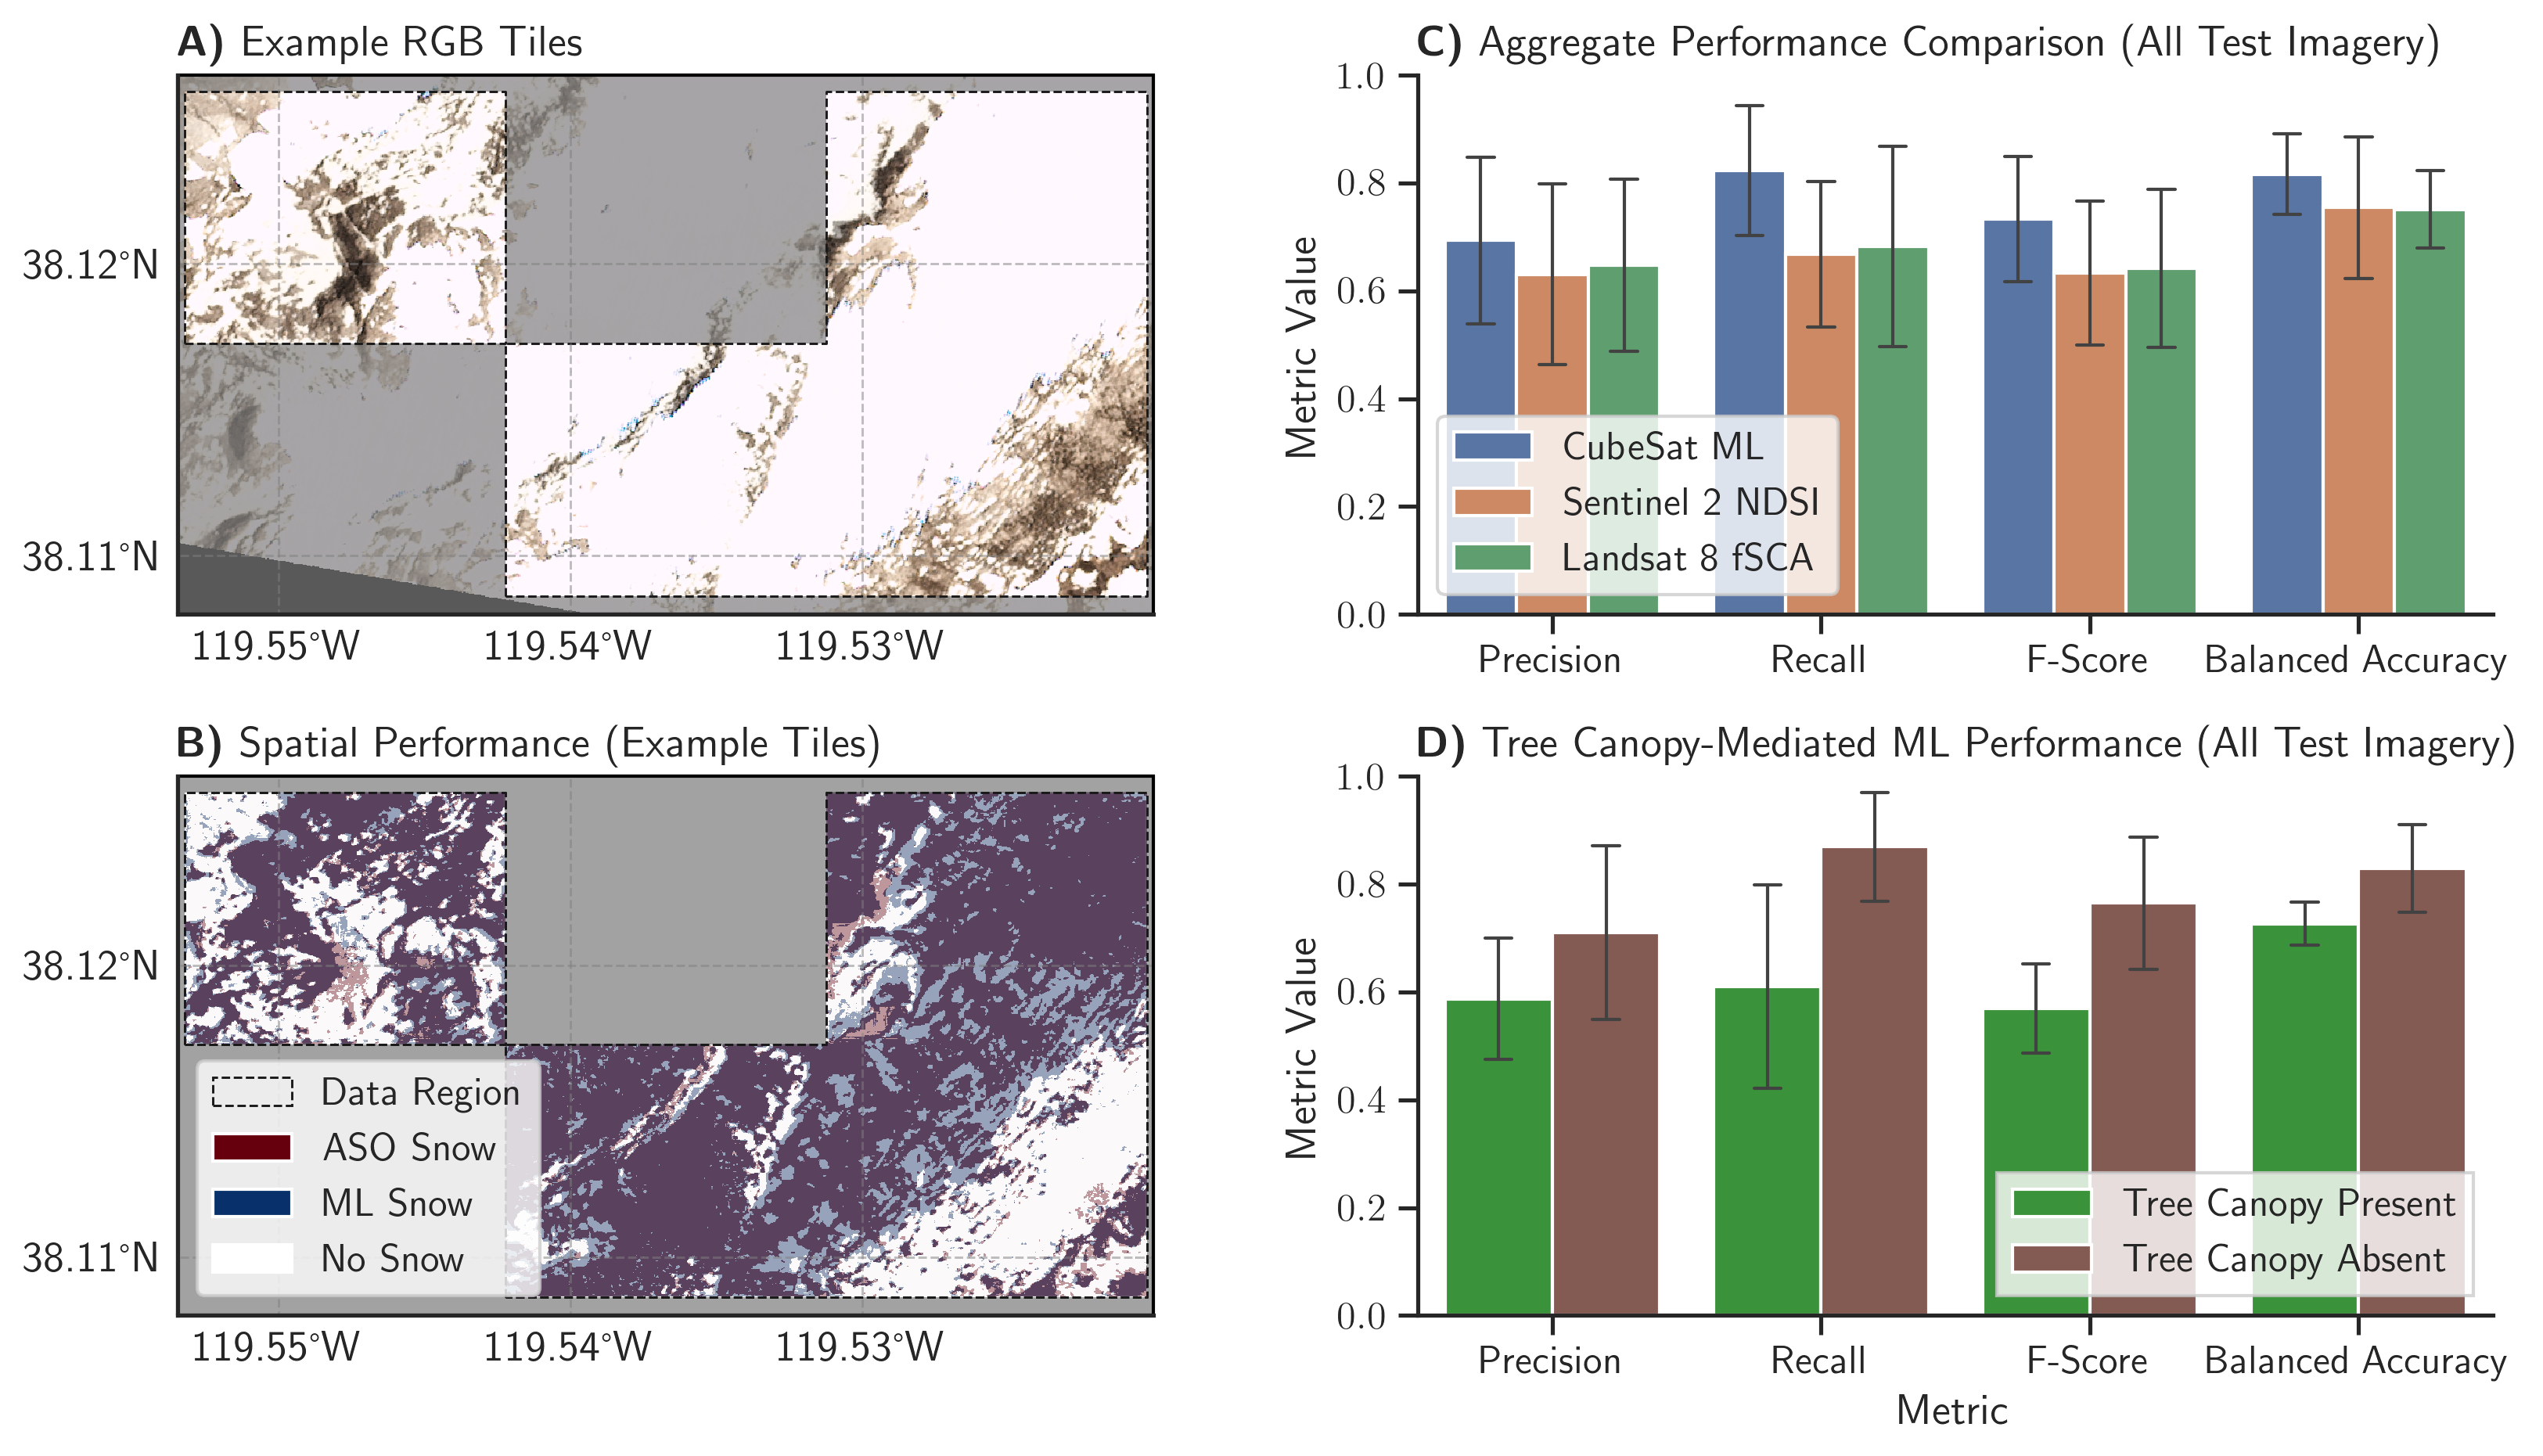

In [25]:
plt.rc('text', usetex=True)
sns.set(style='ticks', font_scale=1.1)

fig = plt.figure(figsize=(13, 7), dpi=300)
grid = fig.add_gridspec(2, 2, width_ratios=[1, 1], hspace=0.3)

ax = fig.add_subplot(grid[0, 0], projection=ccrs.PlateCarree())
ax.imshow(
    np.stack(
        [
            example_visual_image.read(1, masked=True),
            example_visual_image.read(2, masked=True),
            example_visual_image.read(3, masked=True)
        ],
        axis=-1),
    extent=example_visual_image_extent,
    transform=ccrs.PlateCarree(),
    origin='upper')
ax.add_geometries(
    [nodata_diff],
    crs=ccrs.PlateCarree(),
    facecolor='gray',
    alpha=0.7,
    edgecolor='none')
ax.set_extent(visualization_extent)
# ax.text(0.5, 0.95, r"Includes material © 2020 Planet Labs Inc. All Rights Reserved.", transform=ax.transAxes, fontdict={'color': 'white', 'fontsize' : 5})
ax.add_geometries(
    example_data_region.geometry,
    crs=ccrs.PlateCarree(),
    facecolor='none',
    edgecolor='k',
    linestyle='--',
    linewidth=0.7)
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    linewidth=0.7,
    color='gray',
    alpha=0.5,
    linestyle='--',
    draw_labels=True)
gl.xlocator = mticker.FixedLocator(
    [-119.56, -119.55, -119.54, -119.53, -119.52])
gl.ylocator = mticker.FixedLocator([38.10, 38.11, 38.12, 38.13, 38.14])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False
ax.set_title(r"\textbf{A)}" + " Example RGB Tiles", loc='left')

ax = fig.add_subplot(grid[1, 0], projection=ccrs.PlateCarree())
ax.add_geometries(
    [nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.1)

cmap_mask = plt.cm.get_cmap("Reds", 2)
cmap_pred = plt.cm.get_cmap("Blues", 2)
# rgb = np.moveaxis(adjusted_rgb, 0, 2)

# ax.imshow(exposure.equalize_hist(nir_reproject.data), extent=image_reproject_extent, transform=ccrs.PlateCarree(), origin ='upper', cmap='binary')
# ax.imshow(np.moveaxis(exposure.equalize_hist(rgb_reproject), 0, 2), extent=image_reproject_extent, transform=ccrs.PlateCarree(), origin ='upper', cmap='binary')
# ax.imshow(
#     np.stack(
#         [
#             example_visual_image.read(1, masked=True),
#             example_visual_image.read(2, masked=True),
#             example_visual_image.read(3, masked=True)
#         ],
#         axis=-1),
#     extent=example_visual_image_extent,
#     transform=ccrs.PlateCarree(),
#     origin='upper', 
#     alpha=0.7
# )
im = ax.imshow(
    example_ml_predict_data,
    extent=example_ml_predict_extent,
    transform=ccrs.PlateCarree(),
    origin='upper',
    vmin=0.5,
    vmax=1,
    cmap=cmap_pred,
    alpha=0.7)
im = ax.imshow(
    example_aso_mask_data,
    extent=example_aso_mask_extent,
    transform=ccrs.PlateCarree(),
    origin='upper',
    vmin=0.5,
    vmax=1,
    cmap=cmap_mask,
    alpha=0.4)

ax.set_extent(visualization_extent)
ax.add_geometries(
    [nodata_diff],
    crs=ccrs.PlateCarree(),
    facecolor='gray',
    alpha=0.7,
    edgecolor='none')
ax.add_geometries(
    example_data_region.geometry,
    crs=ccrs.PlateCarree(),
    facecolor='none',
    edgecolor='k',
    linestyle='--',
    linewidth=0.7)
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    linewidth=0.7,
    color='gray',
    alpha=0.5,
    linestyle='--',
    draw_labels=True)
gl.xlocator = mticker.FixedLocator(
    [-119.56, -119.55, -119.54, -119.53, -119.52])
gl.ylocator = mticker.FixedLocator([38.10, 38.11, 38.12, 38.13, 38.14])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False
ax.add_geometries(
    example_data_region.geometry,
    crs=ccrs.PlateCarree(),
    facecolor='none',
    edgecolor='k',
    linestyle='--',
    linewidth=0.7)
legendParts = [(Patch(
    facecolor='none',
    edgecolor='k',
    linestyle='--',
    linewidth=0.7,
    label='Data Region')), (Patch(facecolor=cmap_mask(1), label='ASO Snow')),
               (Patch(facecolor=cmap_pred(1), label='ML Snow')), (Patch(
                   facecolor='white', label='No Snow'))]

ax.legend(handles=legendParts, loc='lower left')
ax.set_title(
    r"\textbf{B)}" + " Spatial Performance (Example Tiles)", loc='left')

ax_bars = fig.add_subplot(grid[0, 1])
bp = sns.barplot(
    x='variable',
    hue='SCA',
    y='value',
    ci='sd', capsize=0.1, errwidth=1,
    data=comparative_metrics,
    ax=ax_bars,
    order=['Precision', "Recall", "F-Score",
           "Balanced Accuracy"])  #, capsize=0.1, errwidth=1)
ax_bars.set_ylim([0, 1])
ax_bars.set_xlabel("")
ax_bars.set_ylabel("Metric Value")
# ax.yaxis.set_minor_locator(AutoMinorLocator(2))
# ax_bars.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
# ax_bars.tight_layout()
ax_bars.set_title(
    r"\textbf{C)}" + " Aggregate Performance Comparison (All Test Imagery)",
    loc='left')
ax_bars.get_legend().set_title("")

ax_bars = fig.add_subplot(grid[1, 1])

bars = sns.barplot(
    x='variable',
    y='value',
    hue='type',
    ci = 'sd', 
    capsize=0.1, errwidth=1,
    data=veg_metrics,
    palette=veg_cmap,
    dodge=True)
ax_bars.legend(loc='lower right')
ax_bars.set_ylim([0, 1])
ax_bars.set_xlabel("Metric")
ax_bars.set_ylabel("Metric Value")
ax_bars.set_title(
    r"\textbf{D)}" + " Tree Canopy-Mediated ML Performance (All Test Imagery)",
    loc='left')
h, l = bars.get_legend_handles_labels()
l = [
    r"Tree Canopy Present",
    r"Tree Canopy Absent",
]
bars.legend(h, l, loc='lower right', frameon=True, fancybox=False)
sns.despine()
plt.savefig("tuol-4panel.png", dpi=250, bbox_inches='tight')